In [1]:
from graphviz import Digraph

# Visualizing transacions tree
def visualize_tree(tree):
    
    def add_nodes_edges(node, dot=None):
        if dot is None:
            dot = Digraph()
            dot.attr('node', shape='circle')
            dot.node(name=str(node), label=str(node.value))
            
        for child in node.childs:
            dot.attr('node', shape='circle')
            dot.node(name=str(child), label=str(child.value)+':'+str(child.transactions)+',l='+str(child.level), style='filled', colour='red')    
            dot.edge(str(node), str(child))
            dot = add_nodes_edges(child, dot=dot)
        return dot
    
    dot = add_nodes_edges(tree.root)
    
    display(dot)

In [2]:
class Node:
    def __init__(self, value, level=0, transactions=0, childs=[], parent=None):
        self.value = value
        self.transactions = transactions
        self.parent = parent
        self.level = level
        self.childs = childs.copy()   # remember whenever you assign a list to some other variable you must copy otherwise be ready for your doom

    # Checking if a node has a child
    def has_child(self, child_value):
        for node in self.childs:
            if node.value == child_value:
                return True
        return False
    
    # Go to a child node
    def get_child(self, child_value):
        for node in self.childs:
            if node.value == child_value:
                return node
    
    # Creating a child i.e if this transaction is not part of the path so we need to start a new path
    def create_child(self, child_value):
        child_node = Node(child_value, level=self.level+1, parent=self)  # counter=1 is not done here as incrementation (counter=1) is done for creating a child too in insert
        self.childs.append(child_node)
    
    # Incrementing a transaction of the node
    def increment_transactions(self):
        self.transactions = self.transactions + 1
        
    # check if this node has minimum support
    def has_min_support(self, min_support, total):
        support = self.transactions / total
#         print(self.value, 'has support', support)
        if support >= min_support:
            return True
        return False
    
    # check if node has minimum confidence
    def has_min_confidence(self, min_confidence):
        confidence = self.transactions / self.parent.transactions
#         print(self.value, 'has confidence', confidence)
        if confidence >= min_confidence:
            return True
        return False
    
    # Get this node's branch path i.e all the parents, grandparents etc
    def get_branch_path(self):
        if self.parent.value == 'None':
            return [self.value]
        
        branch_path = self.parent.get_branch_path()
        branch_path.append(self.value)
        return branch_path

class Tree:
    def __init__(self, value):
        self.root = Node(value)
        self.total_transactions = 0
    
    # Inserting a row of transactions
    def insert(self, path):
        self.total_transactions = self.total_transactions + 1
        remaining_path = path.copy()
        current_node = self.root
        
        while True:
            if current_node.has_child(remaining_path[0]) == False:  # If a path does not exist then creating a child
                current_node.create_child(remaining_path[0]) 
                
            current_node = current_node.get_child(remaining_path[0])  # Go to that node
            current_node.increment_transactions()                     # Increment the transactions of the node
            
            remaining_path = remaining_path[1:]
            if remaining_path == []:
                break
    
    # Mining rule with minimum support and minimum confidence
    def mine_rule(self, min_support, min_confidence, stop_level=4):
        queue = [self.root]
        rules = []
        
        while queue:
            current_node = queue.pop(0)
#             print(current_node.value, current_node.level)
            
            if current_node.level > stop_level:  # Don't look beyond this level, you can use this to control num of transactions making a rule
                return rules
            
            elif current_node.level == stop_level:   
                total = self.total_transactions
                if current_node.has_min_support(min_support, total=total) and current_node.has_min_confidence(min_confidence):
                    branch_path = current_node.get_branch_path()
                    branch_path = list( map(str, branch_path) )
                    rule = '->'.join(branch_path[:-1]) + '=>' + branch_path[-1]
                    rules.append(rule)
            
            for child in current_node.childs:
                queue.append(child)
                
        return rules
        
        
                
        
def print_tree(node):
    for child in node.childs:
        print(child.parent.value, child.value)
        print_tree(child)
    

In [3]:
tree = Tree('None')
tree.insert([1,2,3,5])
tree.insert([1,3,4])
tree.insert([2,3])
tree.insert([1,2,4])
tree.insert([1,2,3,5])
tree.insert([1,3,5])
# print_tree(tree.root)
tree.mine_rule(0.3, 0.5)

['1->2->3=>5']

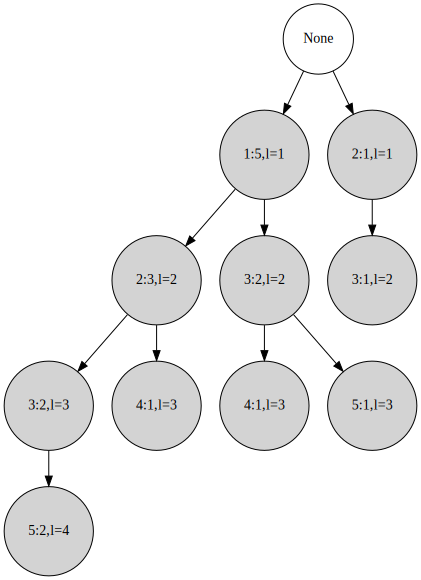

In [4]:
visualize_tree(tree)

In [5]:
# Reading the transactions file
with open('dataset WUM.txt') as file:
    lines = [line.strip('\n').strip(' ') for line in file.readlines()]
#     print(lines[:10])
    web_paths = [line.split(' ') for line in lines]
#     print(web_paths[:10])
    web_paths = [list(map(int, web_path)) for web_path in web_paths]
    print(web_paths[:10])
    
    tree = Tree('None')
    for web_path in web_paths:
        tree.insert(web_path)

[[1, 2, 3, 4], [5, 6, 7, 8, 9, 10, 2, 11, 12, 13], [5, 14], [5, 15, 16, 17], [5, 2, 10, 18, 19], [5, 20], [5, 10, 21, 22], [5, 9, 23, 24, 16, 25], [5, 26], [5, 10, 21, 27, 28]]


In [6]:
# As we can see that no 2 transactions make a rule even with support 10% and confidence 30%
r = tree.mine_rule(min_support=0.1, min_confidence=0.3, stop_level=2)  # stop_level is used for transactions appearing in a rule
print(r)

[]


In [7]:
# So we lower the support and there exists a rule comprising 4 transactions with minimum support 1% and confidence 60%
r = tree.mine_rule(min_support=0.01, min_confidence=0.6, stop_level=4)   # stop_level is used for transactions appearing in a rule
print(r)

['5->9->44=>16']


In [8]:
# visualize_tree(tree)  # We can visualize this tree but its very large so its not that much useful